# Hospital Readmission Prediction - Feature Engineering

This notebook focuses on feature engineering for the hospital readmission prediction model. We'll transform raw features into more informative ones and prepare the data for modeling.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
import warnings

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Ignore warnings
warnings.filterwarnings('ignore')#

## 1. Load the Data

In [12]:
# Load the data
data = pd.read_csv('diabetic_data.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


## 2. Basic Preprocessing

In [13]:
print(f"Dataset shape: {data.shape}")

Dataset shape: (101766, 50)


In [14]:
# Replace '?' with NaN for uniformity
data = data.replace('?', np.nan)
# Drop high-missing columns
missing_threshold = 0.4
high_missing = data.columns[data.isnull().mean() > missing_threshold]
data.drop(columns=high_missing, inplace=True)

In [15]:
#remaining columns who has missing vlaues
missing_percent = data.isna().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
print(missing_percent)


payer_code    39.557416
race           2.233555
diag_3         1.398306
diag_2         0.351787
diag_1         0.020636
dtype: float64


In [16]:
#Demographic data like race

#Insurance codes like payer_code
#Impute with Mode (Most Frequent Category)
for col in ['payer_code', 'race']:
    mode_val = data[col].mode()[0]
    data[col] = data[col].fillna(mode_val)

In [17]:
#Map IDs to Meaningful Labels
admission_type_map = {
    1: 'Emergency',
    2: 'Urgent',
    3: 'Elective',
    4: 'Newborn',
    5: 'Not Available',
    6: 'NULL',
    7: 'Trauma Center',
    8: 'Not Mapped'
}

data['admission_type'] = data['admission_type_id'].map(admission_type_map)
data['admission_type'] = data['admission_type'].replace(
    ['Not Available', 'NULL', 'Not Mapped'], 'Unknown'
)
data.drop(columns=['admission_type_id'], inplace=True)

## 3. Feature Engineering

In [18]:
# 3.1 Extract temporal features
# --- 1. Use existing 'time_in_hospital' as-is and also bin it ---
data['hospital_stay_bin'] = pd.cut(
    data['time_in_hospital'],
    bins=[0, 3, 6, 10, 14],
    labels=['short', 'medium', 'long', 'very_long'],
    right=False
)

# --- 2. Combine number of past visits ---
data['total_visits'] = (
    data['number_inpatient'] +
    data['number_outpatient'] +
    data['number_emergency']
)

# --- 3. Categorize visit frequency ---
def visit_freq(row):
    total = row['total_visits']
    if total == 0:
        return 'new'
    elif total <= 2:
        return 'occasional'
    else:
        return 'frequent'

data['visit_frequency'] = data.apply(visit_freq, axis=1)

# --- 4. Convert 'readmitted' column to binary target ---
# 1 → readmitted within 30 days; 0 → not readmitted or after 30 days
data['readmitted_binary'] = data['readmitted'].apply(lambda x: 1 if x == '<30' else 0)



# Done! Your temporal features are ready.

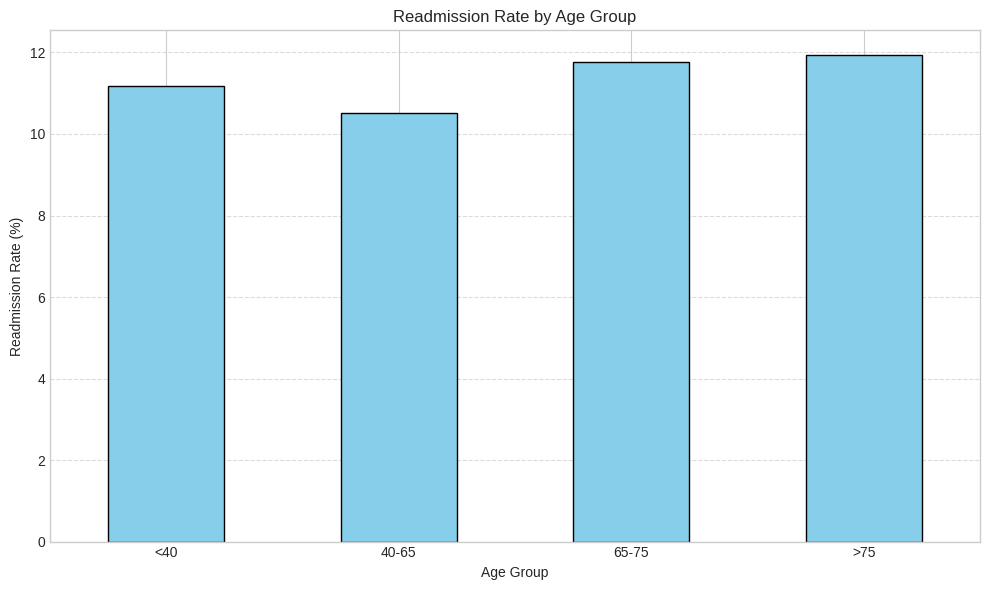

In [19]:
import matplotlib.pyplot as plt

# 1. Map age intervals to three broader age groups
age_group_map = {
    '[0-10)': 'young',
    '[10-20)': 'young',
    '[20-30)': 'young',
    '[30-40)': 'middle-aged',
    '[40-50)': 'middle-aged',
    '[50-60)': 'middle-aged',
    '[60-70)': 'older',
    '[70-80)': 'older',
    '[80-90)': 'older',
    '[90-100)': 'older'
}

data['age_group_3cat'] = data['age'].map(age_group_map)

# 2. Calculate readmission rate per group
readmit_rate_3groups = data.groupby('age_group_3cat')['readmitted_binary'].mean() * 100

# 3. Order the categories
readmit_rate_3groups = readmit_rate_3groups.reindex(['young', 'middle-aged', 'older'])

# 4. Plot
plt.figure(figsize=(8, 5))
readmit_rate_3groups.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Readmission Rate by 3 Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Readmission Rate (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


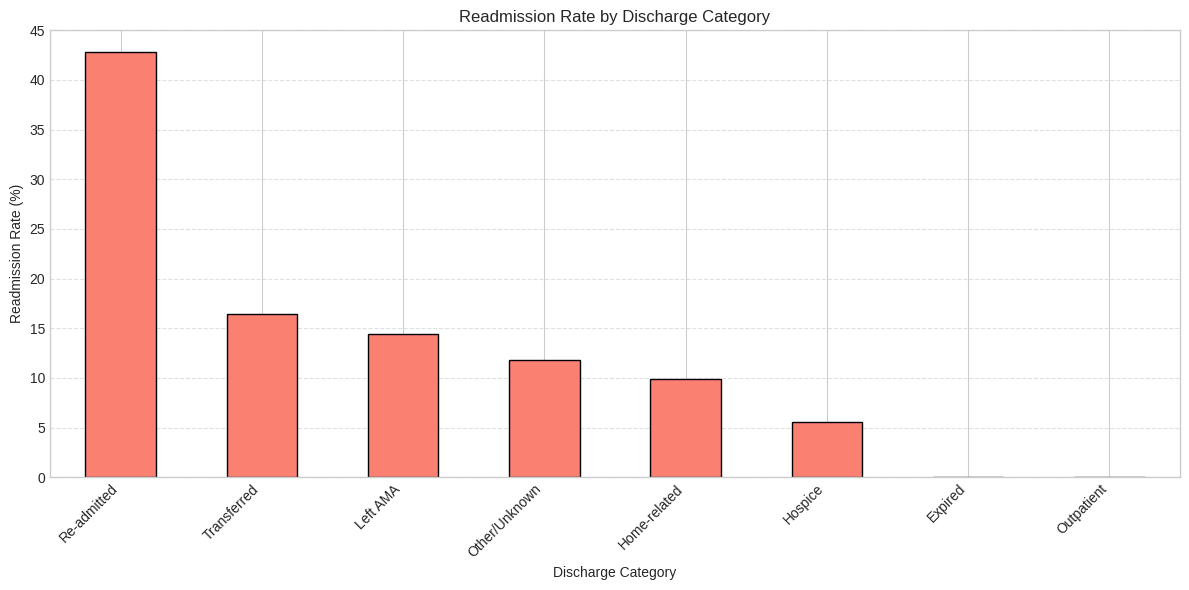

In [21]:
# 1. Define the mapping dictionary
discharge_map = {
    1 : 'Home',
    2 : 'Another short-term hospital',
    3 : 'SNF',
    4 : 'ICF',
    5 : 'Other inpatient care',
    6 : 'Home with health service',
    7 : 'Left AMA',
    8 : 'Home with IV provider',
    9 : 'Re-admitted to same hospital',
    10 : 'Neonate to another hospital',
    11 : 'Expired',
    12 : 'Still patient/outpatient return',
    13 : 'Hospice - home',
    14 : 'Hospice - facility',
    15 : 'Swing bed',
    16 : 'Outpatient services (other)',
    17 : 'Outpatient services (this)',
    18 : 'NULL',
    19 : 'Expired at home (Medicaid, hospice)',
    20 : 'Expired in facility (Medicaid, hospice)',
    21 : 'Expired, place unknown (Medicaid, hospice)',
    22 : 'Rehab facility',
    23 : 'Long-term care hospital',
    24 : 'Nursing facility (Medicaid only)',
    25 : 'Not Mapped',
    26 : 'Unknown/Invalid',
    27 : 'Federal health care facility',
    28 : 'Psychiatric hospital',
    29 : 'Critical Access Hospital (CAH)',
    30 : 'Other health care institution'
}

# 2. Map the values in the dataframe
data['discharge_category'] = data['discharge_disposition_id'].map(discharge_map)

# Optional: Group less frequent categories into "Other" or group similar ones
# Here's an example for grouping into broader categories
def group_discharge(discharge):
    if discharge in ['Home', 'Home with health service', 'Home with IV provider']:
        return 'Home-related'
    elif discharge in ['Expired', 'Expired at home (Medicaid, hospice)', 'Expired in facility (Medicaid, hospice)', 'Expired, place unknown (Medicaid, hospice)']:
        return 'Expired'
    elif 'Hospice' in str(discharge):
        return 'Hospice'
    elif 'Outpatient' in str(discharge):
        return 'Outpatient'
    elif discharge in ['Another short-term hospital', 'SNF', 'ICF', 'Other inpatient care', 'Long-term care hospital', 'Rehab facility', 'Psychiatric hospital', 'Nursing facility (Medicaid only)', 'Federal health care facility', 'Critical Access Hospital (CAH)', 'Swing bed']:
        return 'Transferred'
    elif discharge == 'Left AMA':
        return 'Left AMA'
    elif discharge == 'Re-admitted to same hospital':
        return 'Re-admitted'
    else:
        return 'Other/Unknown'

data['discharge_grouped'] = data['discharge_category'].apply(group_discharge)

# 3. Analyze the readmission rate by discharge group
discharge_readmission = data.groupby('discharge_grouped')['readmitted_binary'].mean().sort_values(ascending=False) * 100

# 4. Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
discharge_readmission.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Readmission Rate by Discharge Category')
plt.xlabel('Discharge Category')
plt.ylabel('Readmission Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   encounter_id              101766 non-null  int64   
 1   patient_nbr               101766 non-null  int64   
 2   race                      101766 non-null  object  
 3   gender                    101766 non-null  object  
 4   age                       101766 non-null  object  
 5   discharge_disposition_id  101766 non-null  int64   
 6   admission_source_id       101766 non-null  int64   
 7   time_in_hospital          101766 non-null  int64   
 8   payer_code                101766 non-null  object  
 9   num_lab_procedures        101766 non-null  int64   
 10  num_procedures            101766 non-null  int64   
 11  num_medications           101766 non-null  int64   
 12  number_outpatient         101766 non-null  int64   
 13  number_emergency          101

In [ ]:
# 3.3 Create interaction features
data['age_heart_failure'] = data['age'] * data['heart_failure']
data['age_diabetes'] = data['age'] * data['diabetes']
data['previous_emergency'] = data['previous_admissions'] * data['emergency_admission']
data['medication_count_adherence'] = data['medication_count'] * data['medication_adherence']
data['comorbidity_count'] = data[['diabetes', 'heart_failure', 'copd', 'hypertension', 'renal_disease']].sum(axis=1)

# Visualize readmission rate by comorbidity count
comorbidity_readmission = data.groupby('comorbidity_count')['readmission_30d'].mean() * 100

plt.figure(figsize=(10, 6))
comorbidity_readmission.plot(kind='bar')
plt.title('Readmission Rate by Number of Comorbidities')
plt.xlabel('Number of Comorbidities')
plt.ylabel('Readmission Rate (%)')
plt.show()

In [ ]:
# 3.4 Create risk score based on domain knowledge
data['risk_score'] = (
    0.2 * (data['age'] > 75).astype(int) +
    0.15 * data['diabetes'] +
    0.25 * data['heart_failure'] +
    0.2 * data['copd'] +
    0.1 * data['renal_disease'] +
    0.05 * (data['previous_admissions'] > 2).astype(int) +
    0.15 * (data['medication_count'] > 8).astype(int) -
    0.3 * data['medication_adherence'] +
    0.1 * data['emergency_admission'] +
    0.1 * (data['discharge_disposition'] == 2).astype(int)
)

# Visualize risk score distribution by readmission status
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='risk_score', hue='readmission_30d', bins=30, multiple='dodge')
plt.title('Risk Score Distribution by Readmission Status')
plt.xlabel('Risk Score')
plt.ylabel('Count')
plt.legend(['Not Readmitted', 'Readmitted'])
plt.show()

In [ ]:
# 3.5 One-hot encode categorical variables
data_encoded = pd.get_dummies(data, columns=['gender', 'age_group', 'primary_diagnosis', 'discharge_disposition'], drop_first=True)

print(f"Shape after one-hot encoding: {data_encoded.shape}")
print(f"New features added: {data_encoded.shape[1] - data.shape[1]}")

## 4. Feature Selection

In [ ]:
# Prepare data for feature selection
# Drop non-feature columns
X = data_encoded.drop(columns=['patient_id', 'admission_date', 'discharge_date', 'readmission_30d', 'days_to_readmission'])
y = data_encoded['readmission_30d']

print(f"Features shape: {X.shape}")

In [ ]:
# 4.1 Feature importance using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the top 20 features
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), X.columns[indices][:20], rotation=90)
plt.tight_layout()
plt.show()

# Print top 20 features
print("Top 20 features by importance:")
for i in range(20):
    print(f"{i+1}. {X.columns[indices][i]}: {importances[indices][i]:.4f}")

In [ ]:
# 4.2 Statistical feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=20)
X_new = selector.fit_transform(X, y)

# Get selected feature names
mask = selector.get_support()
selected_features = X.columns[mask]

# Get scores
scores = selector.scores_
selected_scores = scores[mask]

# Sort by score
sorted_indices = np.argsort(selected_scores)[::-1]
sorted_features = selected_features[sorted_indices]
sorted_scores = selected_scores[sorted_indices]

# Plot
plt.figure(figsize=(12, 8))
plt.title('Feature Selection using ANOVA F-value')
plt.bar(range(len(sorted_features)), sorted_scores, align='center')
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.tight_layout()
plt.show()

print("Top 20 features by ANOVA F-value:")
for i, (feature, score) in enumerate(zip(sorted_features, sorted_scores)):
    print(f"{i+1}. {feature}: {score:.4f}")

In [ ]:
# 4.3 Recursive Feature Elimination (RFE)
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=20)
rfe.fit(X, y)

# Get selected feature names
rfe_mask = rfe.get_support()
rfe_features = X.columns[rfe_mask]

print("Top 20 features selected by RFE:")
for i, feature in enumerate(rfe_features):
    print(f"{i+1}. {feature}")

## 5. Compare Feature Selection Methods

In [ ]:
# Compare the features selected by different methods
rf_features = X.columns[indices][:20]
anova_features = sorted_features

# Find common features
common_all = set(rf_features) & set(anova_features) & set(rfe_features)
common_rf_anova = set(rf_features) & set(anova_features)
common_rf_rfe = set(rf_features) & set(rfe_features)
common_anova_rfe = set(anova_features) & set(rfe_features)

print(f"Features common to all methods: {len(common_all)}")
print(f"Features common to RF and ANOVA: {len(common_rf_anova)}")
print(f"Features common to RF and RFE: {len(common_rf_rfe)}")
print(f"Features common to ANOVA and RFE: {len(common_anova_rfe)}")

print("\nFeatures common to all methods:")
for feature in common_all:
    print(f"- {feature}")

## 6. Final Feature Set

In [ ]:
# Create a final feature set based on the analysis
# We'll use features that appear in at least 2 of the 3 methods
all_selected_features = list(rf_features) + list(anova_features) + list(rfe_features)
feature_counts = pd.Series(all_selected_features).value_counts()
final_features = feature_counts[feature_counts >= 2].index.tolist()

print(f"Final feature set size: {len(final_features)}")
print("\nFinal features:")
for feature in final_features:
    print(f"- {feature}")

In [ ]:
# Create the final feature matrix
X_final = X[final_features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# Convert back to DataFrame for better visualization
X_scaled_data = pd.DataFrame(X_scaled, columns=X_final.columns)

print(f"Final scaled feature matrix shape: {X_scaled_data.shape}")
X_scaled_data.head()

## 7. Save Processed Data

In [ ]:
# Save the final feature set for reference
import os
os.makedirs('../data/features', exist_ok=True)

# Save the list of final features
with open('../data/features/final_features.txt', 'w') as f:
    for feature in final_features:
        f.write(f"{feature}\n")

print(f"Final feature list saved to ../data/features/final_features.txt")

In [ ]:
# Save the full processed dataset
# Add the target variable back
X_scaled_data['readmission_30d'] = y.values

# Save to CSV
X_scaled_data.to_csv('../data/features/processed_features.csv', index=False)
print(f"Processed features saved to ../data/features/processed_features.csv")

## 8. Summary of Feature Engineering

In this notebook, we performed several feature engineering steps:

1. **Temporal Features**:
   - Extracted month, day of week, and quarter from admission date
   - Created a weekend admission indicator

2. **Categorical Transformations**:
   - Created age groups
   - One-hot encoded categorical variables

3. **Interaction Features**:
   - Combined age with medical conditions
   - Created previous emergency admissions
   - Combined medication count and adherence
   - Created comorbidity count

4. **Domain Knowledge Features**:
   - Created a risk score based on clinical factors

5. **Feature Selection**:
   - Used Random Forest importance
   - Applied ANOVA F-value selection
   - Performed Recursive Feature Elimination
   - Selected features that appeared in at least 2 methods

6. **Feature Scaling**:
   - Standardized the final feature set

The final feature set includes a mix of demographic, medical, temporal, and interaction features that show strong predictive power for hospital readmissions.